In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR  

In [2]:
#Safe LabelEncoder ƒë·ªÉ tr√°nh l·ªói KeyError
class SafeLabelEncoder(LabelEncoder):
    def transform(self, values):
        return [np.where(self.classes_ == val)[0][0] if val in self.classes_ else -1 for val in values]

In [4]:
# ƒê·ªçc d·ªØ li·ªáu
train_df = pd.read_csv('../Dataset/712/train.csv')
valid_df = pd.read_csv('../Dataset/712/validation.csv')
test_df = pd.read_csv('../Dataset/712/test.csv')

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [5]:
# 2. H√†m ti·ªÅn x·ª≠ l√Ω
def preprocess(df, encoders=None, scaler=None, is_train=True):
    df = df.copy()

    # C·ªôt ph√¢n lo·∫°i & s·ªë
    categorical_cols = ['film_code', 'cinema_code', 'month', 'quarter', 'day', 'year']
    numerical_cols = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc', 'ticket_use', 'capacity']
    target_col = 'total_sales'

    # Encode c·ªôt ph√¢n lo·∫°i
    if is_train:
        encoders = {col: SafeLabelEncoder().fit(df[col].astype(str)) for col in categorical_cols}
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col].astype(str))

    # Scale s·ªë
    if is_train:
        scaler = StandardScaler().fit(df[numerical_cols])
    df[numerical_cols] = scaler.transform(df[numerical_cols])

    # T·∫≠p d·ªØ li·ªáu
    X = df[categorical_cols + numerical_cols]
    y = df[target_col] if target_col in df.columns else None

    return X, y, encoders, scaler

In [6]:
# 3. Chu·∫©n h√≥a d·ªØ li·ªáu 
X_train, y_train, encoders, scaler = preprocess(train_df, is_train=True)
X_valid, y_valid, _, _ = preprocess(valid_df, encoders, scaler, is_train=False)
X_test, _, _, _ = preprocess(test_df, encoders, scaler, is_train=False)


In [7]:
# Kh·ªüi t·∫°o dataset cho PyTorch
class SalesDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

train_data = SalesDataset(X_train, y_train)
valid_data = SalesDataset(X_valid, y_valid)
test_data = SalesDataset(X_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

# SVM Regressor
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Hu·∫•n luy·ªán m√¥ h√¨nh SVM
svm_model.fit(X_train, y_train)


SVR()

In [ ]:
val_preds = svm_model.predict(X_valid)
val_mae = mean_absolute_error(y_valid, val_preds)
val_mse = mean_squared_error(y_valid, val_preds)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_valid, val_preds)

print(f"[VALIDATION] MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R¬≤: {val_r2:.2f}")

# Test
test_preds = svm_model.predict(X_test)

# N·∫øu test_df c√≥ c·ªôt 'total_sales' (d√πng ƒë·ªÉ t√≠nh test_true), c√≤n kh√¥ng th√¨ b·ªè ƒë√°nh gi√° test
if 'total_sales' in test_df.columns:
    test_true = test_df['total_sales'].values
    test_mae = mean_absolute_error(test_true, test_preds)
    test_mse = mean_squared_error(test_true, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_true, test_preds)

    print(f"[TEST] MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R¬≤: {test_r2:.2f}")


[VALIDATION] MAE: 12979706.57, MSE: 1349920767684226.50, RMSE: 36741267.91, R¬≤: -0.10
[TEST] MAE: 11084384.09, MSE: 1056609763968118.25, RMSE: 32505534.36, R¬≤: -0.08


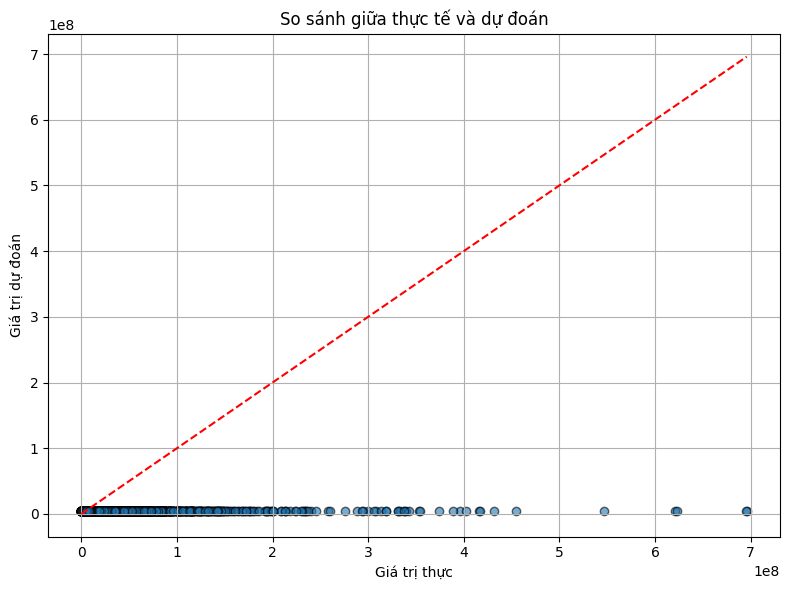

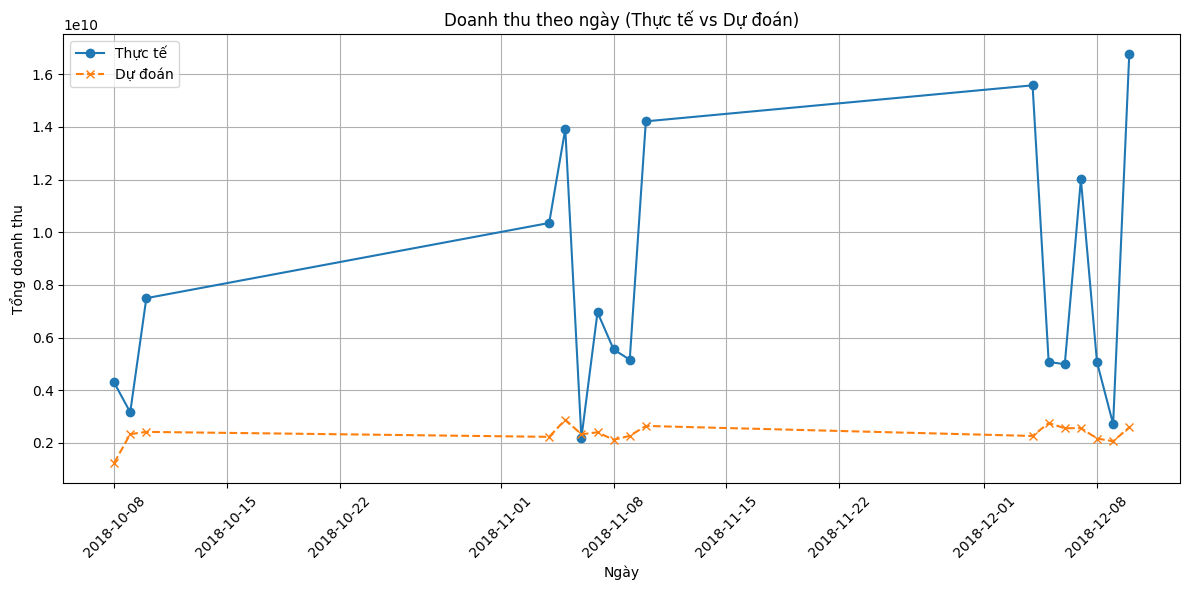

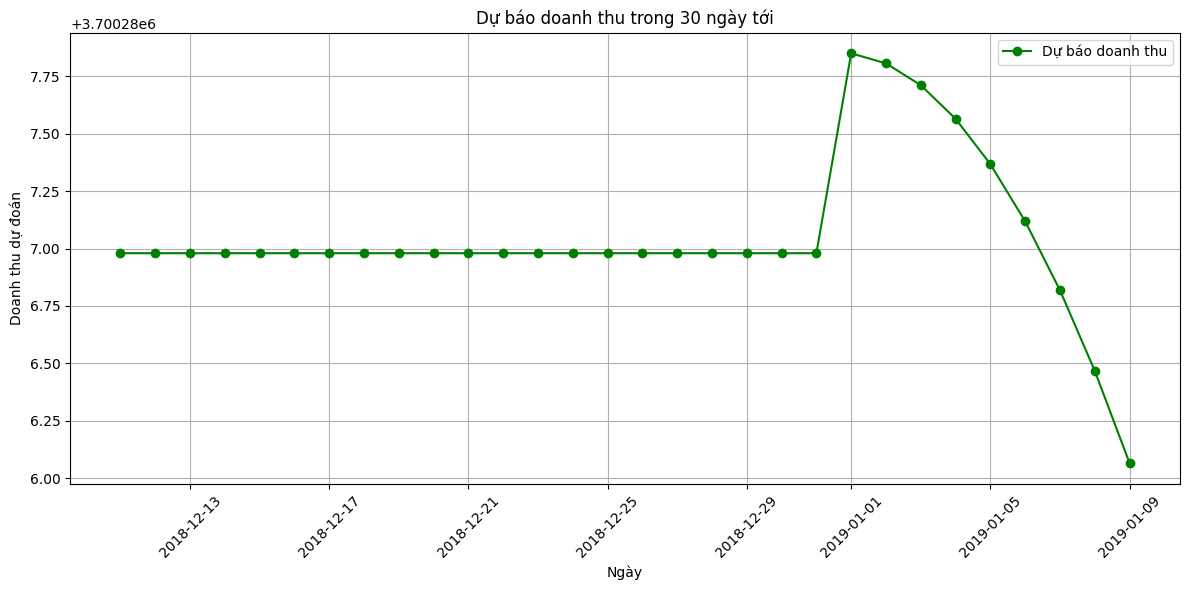

In [11]:
# üëâ S·ª≠a ƒëo·∫°n scatter: d√πng test_true thay v√¨ y_test
if 'total_sales' in test_df.columns:
    test_true = test_df['total_sales'].values
    test_df['ActualSales'] = test_true
    test_df['PredictedSales'] = test_preds

    # 9. V·∫Ω scatter: Gi√° tr·ªã th·ª±c vs D·ª± ƒëo√°n
    plt.figure(figsize=(8, 6))
    plt.scatter(test_true, test_preds, alpha=0.6, edgecolors='k')
    plt.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'r--')
    plt.xlabel('Gi√° tr·ªã th·ª±c')
    plt.ylabel('Gi√° tr·ªã d·ª± ƒëo√°n')
    plt.title('So s√°nh gi·ªØa th·ª±c t·∫ø v√† d·ª± ƒëo√°n')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("[!] Kh√¥ng th·ªÉ v·∫Ω scatter v√¨ thi·∫øu 'total_sales' trong test_df")

# 10. V·∫Ω doanh thu theo ng√†y
if 'date' in test_df.columns and 'ActualSales' in test_df.columns:
    test_df['date'] = pd.to_datetime(test_df['date'])
    
    daily = test_df.groupby(test_df['date'].dt.date).agg({
        'ActualSales': 'sum',
        'PredictedSales': 'sum'
    }).reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(daily['date'], daily['ActualSales'], label='Th·ª±c t·∫ø', marker='o')
    plt.plot(daily['date'], daily['PredictedSales'], label='D·ª± ƒëo√°n', linestyle='--', marker='x')
    plt.xlabel('Ng√†y')
    plt.ylabel('T·ªïng doanh thu')
    plt.title('Doanh thu theo ng√†y (Th·ª±c t·∫ø vs D·ª± ƒëo√°n)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("[!] test_df kh√¥ng c√≥ c·ªôt 'date' ho·∫∑c 'ActualSales'")

# 11. D·ª± ƒëo√°n doanh thu cho 30 ng√†y ti·∫øp theo b·∫±ng SVR
if 'date' in test_df.columns:
    last_date = pd.to_datetime(test_df['date']).max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

    # L·∫•y m·∫´u d·ªØ li·ªáu cu·ªëi c√πng ƒë·ªÉ m√¥ ph·ªèng
    last_sample = test_df.tail(1).copy()
    future_preds = []

    for date in future_dates:
        future_sample = last_sample.copy()
        future_sample['date'] = date

        # C√≥ th·ªÉ c·∫ßn ch·ªânh l·∫°i c√°c c·ªôt 'month', 'day', 'year', 'quarter'
        future_sample['month'] = date.month
        future_sample['day'] = date.day
        future_sample['year'] = date.year
        future_sample['quarter'] = (date.month - 1) // 3 + 1

        # D·ª± ƒëo√°n
        X_future, _, _, _ = preprocess(future_sample, encoders, scaler, is_train=False)
        pred = svm_model.predict(X_future)[0]
        future_preds.append(pred)

    # T·∫°o dataframe k·∫øt qu·∫£
    future_df = pd.DataFrame({'date': future_dates, 'PredictedSales': future_preds})

    # V·∫Ω bi·ªÉu ƒë·ªì
    plt.figure(figsize=(12, 6))
    plt.plot(future_df['date'], future_df['PredictedSales'], color='green', marker='o', label='D·ª± b√°o doanh thu')
    plt.xlabel('Ng√†y')
    plt.ylabel('Doanh thu d·ª± ƒëo√°n')
    plt.title('D·ª± b√°o doanh thu trong 30 ng√†y t·ªõi')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("[!] test_df kh√¥ng c√≥ c·ªôt 'date', kh√¥ng th·ªÉ d·ª± ƒëo√°n t∆∞∆°ng lai.")
